# Webscraping and beyond

**Ruthger Righart**

Email: rrighart@googlemail.com
Website: www.rrighart.com

Data is the new oil of the 21st century<font color="gray"><sup>1</sup></font>. Many data come from the web<font color="gray"><sup>2</sup></font>. Acquiring these webdata and structuring them is an essential skill that is called *webscraping*.

In this blog, I am going to briefly discuss how to webscrape data. However, it does not stop there. Analyses beyond webscraping are often needed. Some additional steps are shown, such as capturing hidden characters, merging different data, summary stats and visualization etc. Luckily, Python can be used for the whole analysis pipeline.

Healthdata are used for the current purpose, but it should be mentioned that many data can be webscraped in a similar way, sometimes with a few adaptations in the code.

**Important note**: Almost nothing is more dynamic than webdata. I have attempted to take a data example from Wikipedia that should remain rather stable over time. 
The code in the current blog is based on **Python 2.7**. Please note that minor changes in code for Python 3 are needed.

If you discover any error or something in the code that does not work, please do not hesitate to contact me.


In [1]:
import warnings
warnings.filterwarnings("ignore")

## **Healthcare rankings for different European countries** 

**Beautiful Soup** is a Python package that is used for webscraping<font color="gray"><sup>3</sup></font>. 
In this blog we are going to use webscraping to scrape tables from webpages.

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import csv
import re
import urllib2
from datetime import datetime
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

First, you need to determine the directory where you save your data.  

In [ ]:
os.chdir('/your-directory/')
os.getcwd()

We are going to scrape data from wikipedia<font color="gray"><sup>4</sup></font>. The data indicate rankings on different health indices, such as patient rights and information, accessibility (waiting time for treatment), outcomes, range and reach of services provided, prevention, and pharmaceuticals. The data are from the Euro Health Consumer index 2014. In the following code, we read the data and use BeautifulSoup to convert the data in so-called **bs4.BeautifulSoup** data. Several data visualizations using Tableau can be found on my blog page<font color="gray"><sup>5</sup></font>.

In [4]:
url = 'https://en.wikipedia.org/wiki/Healthcare_in_Europe' 
r = requests.get(url)
HCE = BeautifulSoup(r.content)
type(HCE)

bs4.BeautifulSoup

We could display the data using <font color="blue">print(HCE.prettify())</font>. We will not do that here because it gives a great amount of text (or soup).

We first need to select the table that we'd like to scrape. As many webpages contain multiple tables (as is the case for the current example), it would be good to read from the HTML the tablenames into a list, that we will call <font color="red">lst</font><font color="gray"><sup>6</sup></font>. The following piece of code exactly does that:

In [5]:
htmlpage = urllib2.urlopen(url)
lst = []
for line in htmlpage:
    line = line.rstrip()
    if re.search('table class', line) :
        lst.append(line)

This list <font color="red">lst</font> has a length of 2:

In [6]:
len(lst)

2

Now let us display <font color="red">lst</font>:

In [7]:
lst

['<table class="wikitable sortable">',
 '<table class="nowraplinks collapsible autocollapse navbox-inner" style="border-spacing:0;background:transparent;color:inherit">']

We will scrape the first table, and therefore use index 0 in <font color="red">lst</font> to capture the first table name:

In [8]:
x=lst[0]
print x
extr=re.findall('"([^"]*)"', x)

<table class="wikitable sortable">


Now it is about time to read in the table using Beautiful Soup's <font color="blue">find</font> function. A simple option is to type in the table name. You simply select the name in <font color="red">lst</font>, which in this case is "wikitable sortable":

In [9]:
table=HCE.find('table', {'class', 'wikitable sortable'})

Alternatively, there is a way to automate this step, by capturing the first data from the list, and then stripping off the unneeded characters.

In [10]:
table=HCE.find('table', {'class', str(extr).strip("'[]'")})

In [11]:
type(table)

bs4.element.Tag

Now it would be good to read in separately the header names and rows, sothat later we can easily make a DataFrame.

In [12]:
headers= [header.text for header in table.find_all('th')]

In [13]:
headers

[u'Country',
 u'Overall ranking',
 u'Patient rights and\ninformation ranking',
 u'Accessibility\n(waiting times for\ntreatment) ranking',
 u'Outcomes\nranking',
 u'Range and reach of\nservices provided',
 u'Prevention',
 u'Pharmaceuticals']

In [14]:
rows = []
for row in table.find_all('tr'):
    rows.append([val.text.encode('utf8') for val in row.find_all('td')])

Rows look as follows and are of the type list:

In [15]:
for x in range(0,7):
    print(x, rows[x])

(0, [])
(1, ['\xc2\xa0Netherlands', '1', '1', '7', '1', '1', '13', '1'])
(2, ['\xc2\xa0\xc2\xa0Switzerland', '2', '12', '1', '3', '14', '6', '9'])
(3, ['\xc2\xa0Norway', '3', '22', '22', '1', '3', '1', '7'])
(4, ['\xc2\xa0Finland', '4', '6', '10', '6', '4', '6', '1'])
(5, ['\xc2\xa0Denmark', '5', '2', '4', '9', '6', '13', '9'])
(6, ['\xc2\xa0Belgium', '6', '22', '1', '9', '4', '19', '9'])


Now all element, -- rows and headers --, are available to build the DataFrame, which we will call <font color="red">df1</font>. 

In [16]:
df1 = pd.DataFrame(rows, columns=headers)

In [17]:
df1.head(7)

,Country,Overall ranking,Patient rights and information ranking,Accessibility (waiting times for treatment) ranking,Outcomes ranking,Range and reach of services provided,Prevention,Pharmaceuticals
0,None,None,None,None,None,None,None,None
1,Netherlands,1,1,7,1,1,13,1
2,Switzerland,2,12,1,3,14,6,9
3,Norway,3,22,22,1,3,1,7
4,Finland,4,6,10,6,4,6,1
5,Denmark,5,2,4,9,6,13,9
6,Belgium,6,22,1,9,4,19,9


## **Health Expenditure**

Of course, we can do the same for other data sources. So let us load data about health expenditure<font color="gray"><sup>7</sup></font>. These are data per capita, which means that expenditure was corrected for the number of habitants in a country. We are now going to put the script in one code block, which eventually should lead to a DataFrame <font color="red">df2</font>:

In [18]:
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_total_health_expenditure_per_capita' 
r = requests.get(url)
HEE = BeautifulSoup(r.content)
htmlpage = urllib2.urlopen(url)
lst = []
for line in htmlpage:
    line = line.rstrip()
    if re.search('table class', line) :
        lst.append(line)
x=lst[1]
print x
extr=re.findall('"([^"]*)"', x)
table=HEE.find('table', {'class', str(extr).strip("'[]'")})
headers= [header.text for header in table.find_all('th')]
rows = []
for row in table.find_all('tr'):
    rows.append([val.text.encode('utf8') for val in row.find_all('td')])
df2 = pd.DataFrame(rows, columns=headers)

<table class="wikitable sortable">


Alright. Let us inspect if the resulting DataFrame <font color="red">df2</font> looks fine:

In [19]:
df2.head(7)

,Country,2012,2013,2014,2015
0,None,None,None,None,None
1,Australia,3808,4177,4207,4420
2,Austria,4646,4806,4896,5016
3,Belgium,4286,4485,4522,4611
4,Canada,4320,4503,4492,4608
5,Chile,1485,1558,1689,1728
6,Czech Republic,2028,2330,2386,2464



## **Additional preprocessing steps**

If we use <font color="blue">df1.dtypes</font> and do the same for <font color="red">df2</font> we will see that the columns are still objects. That means that no calculations can be performed on these columns.

In [20]:
df1.dtypes

Country                                                  object
Overall ranking                                          object
Patient rights and\ninformation ranking                  object
Accessibility\n(waiting times for\ntreatment) ranking    object
Outcomes\nranking                                        object
Range and reach of\nservices provided                    object
Prevention                                               object
Pharmaceuticals                                          object
dtype: object

In the following we will convert the data from object to numeric:

In [21]:
df1 = df1.convert_objects(convert_numeric=True)

In [22]:
df2 = df2.convert_objects(convert_numeric=True)

And now we check if the data type changed:

In [23]:
df1.dtypes

Country                                                   object
Overall ranking                                          float64
Patient rights and\ninformation ranking                  float64
Accessibility\n(waiting times for\ntreatment) ranking    float64
Outcomes\nranking                                        float64
Range and reach of\nservices provided                    float64
Prevention                                               float64
Pharmaceuticals                                          float64
dtype: object

In [24]:
df2.dtypes

Country     object
2012       float64
2013       float64
2014       float64
2015       float64
dtype: object

The columnnames are a bit long, and so it would be good to use shorter names.

In [25]:
df1.columns

Index([u'Country', u'Overall ranking',
       u'Patient rights and\ninformation ranking',
       u'Accessibility\n(waiting times for\ntreatment) ranking',
       u'Outcomes\nranking', u'Range and reach of\nservices provided',
       u'Prevention', u'Pharmaceuticals'],
      dtype='object')

In [26]:
df1.columns = ['Country', 'Ranking', 'Patientrights', 'Accessibility', 'Outcomes', 'Range', 'Prevention', 'Pharmaceuticals']

The summary statistics show that calculations can be performed:

In [27]:
df1.describe()

,Ranking,Patientrights,Accessibility,Outcomes,Range,Prevention,Pharmaceuticals
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,19.000000,18.864865,17.810811,17.729730,18.189189,17.000000,17.270270
std,10.824355,10.349885,10.723385,10.889977,10.823939,11.147994,10.872107
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,10.000000,10.000000,10.000000,9.000000,9.000000,6.000000,9.000000
50%,19.000000,19.000000,19.000000,16.000000,19.000000,19.000000,19.000000
75%,28.000000,28.000000,27.000000,26.000000,28.000000,26.000000,28.000000
max,37.000000,37.000000,37.000000,36.000000,37.000000,37.000000,36.000000


That looks good. But we need a bit of more processing. For example, a first row (index zero) with only "None" values slipped in and could be removed. After, we also change columnnames:

In [28]:
df1 = df1.drop(df1.index[0])

In [29]:
df2 = df2.drop(df2.index[0])

In [30]:
df2.columns = ['Country', 'y2012', 'y2013', 'y2014', 'y2015']

In [31]:
df2.head(5)

,Country,y2012,y2013,y2014,y2015
1,Australia,3808.0,4177.0,4207.0,4420.0
2,Austria,4646.0,4806.0,4896.0,5016.0
3,Belgium,4286.0,4485.0,4522.0,4611.0
4,Canada,4320.0,4503.0,4492.0,4608.0
5,Chile,1485.0,1558.0,1689.0,1728.0



## **Merging different data**

It should be clear from this example that webscraping can be important to quickly grasp data.
Webscraping may be particularly useful when you need to automate the data processing:

* Webdata change regularly and need to be stored repeatedly.

* A large number of data sources, for example tables, need to be loaded and merged.

So let us elaborate the last point a bit more. If the two tables that we just scraped need to be merged, this can be done in Python. For example, if we want to merge on the column "Country", we would use the following code (for the moment we use the <font color="blue">.head()</font> function to limit the output).

In [32]:
pd.merge(df1,df2, how='left', on='Country').head(10)

,Country,Ranking,Patientrights,Accessibility,Outcomes,Range,Prevention,Pharmaceuticals,y2012,y2013,y2014,y2015
0,Netherlands,1.0,1.0,7.0,1.0,1.0,13.0,1.0,NaN,NaN,NaN,NaN
1,Switzerland,2.0,12.0,1.0,3.0,14.0,6.0,9.0,NaN,NaN,NaN,NaN
2,Norway,3.0,22.0,22.0,1.0,3.0,1.0,7.0,NaN,NaN,NaN,NaN
3,Finland,4.0,6.0,10.0,6.0,4.0,6.0,1.0,NaN,NaN,NaN,NaN
4,Denmark,5.0,2.0,4.0,9.0,6.0,13.0,9.0,NaN,NaN,NaN,NaN
5,Belgium,6.0,22.0,1.0,9.0,4.0,19.0,9.0,NaN,NaN,NaN,NaN
6,Iceland,7.0,4.0,14.0,3.0,9.0,1.0,21.0,NaN,NaN,NaN,NaN
7,Luxemburg,8.0,17.0,7.0,6.0,6.0,5.0,16.0,NaN,NaN,NaN,NaN
8,Germany,9.0,10.0,7.0,3.0,21.0,6.0,1.0,NaN,NaN,NaN,NaN
9,Austria,10.0,9.0,4.0,16.0,11.0,19.0,9.0,NaN,NaN,NaN,NaN


If you removed the <font color="blue">head()</font> function and printed out everything, you would see that all the health expenditure data give unexpected NaNs (missing values). Something must be wrong here. 

So we need to inspect this in more detail. Normally using the <font color="blue">set</font> function to check for overlap between the countries in the two DataFrames should give a set. But now it is empty. This may suggest that the tables cannot merge because the <font color="red">Country</font> names are not identical.

In [33]:
set(df1['Country']) & set(df2['Country'])

set()

Let's inspect these tables more closely. Something must be wrong because there are several countries that are overlapping and there are no spelling errors. If we write the table to a csv file to check the raw text we may discover hidden symbols.

In [34]:
df1.to_csv('df1example.csv', sep=",")
df2.to_csv('df2example.csv', sep=",")

If you now open the csv file in a spreadsheet software you would discover that there are some hidden characters in the <font color="red">df1example.csv</font> file. 

Using the <font color="blue">repr</font> function we can reveal the hidden characters<sup>8</sup>.

In [36]:
repr(df1['Country'])

'1                \xc2\xa0Netherlands\n2               \xc2\xa0\xc2\xa0Switzerland\n3                     \xc2\xa0Norway\n4                    \xc2\xa0Finland\n5                    \xc2\xa0Denmark\n6                    \xc2\xa0Belgium\n7                    \xc2\xa0Iceland\n8                  \xc2\xa0Luxemburg\n9                    \xc2\xa0Germany\n10                   \xc2\xa0Austria\n11                    \xc2\xa0France\n12                    \xc2\xa0Sweden\n13                  \xc2\xa0Portugal\n14                   \xc2\xa0England\n15            \xc2\xa0Czech Republic\n16                  \xc2\xa0Scotland\n17                 \xc2\xa0Macedonia\n18                   \xc2\xa0Estonia\n19                     \xc2\xa0Spain\n20                  \xc2\xa0Slovenia\n21                  \xc2\xa0Slovakia\n22                     \xc2\xa0Italy\n23                   \xc2\xa0Ireland\n24                   \xc2\xa0Croatia\n25                    \xc2\xa0Cyprus\n26                   \xc2\xa0Hungary\n27  

In [37]:
repr(df2['Country'])

'1           Australia\n2             Austria\n3             Belgium\n4              Canada\n5               Chile\n6      Czech Republic\n7             Denmark\n8             Estonia\n9             Finland\n10             France\n11            Germany\n12             Greece\n13            Hungary\n14            Iceland\n15            Ireland\n16             Israel\n17              Italy\n18              Japan\n19              Korea\n20             Latvia\n21         Luxembourg\n22             Mexico\n23        Netherlands\n24        New Zealand\n25             Norway\n26             Poland\n27           Portugal\n28    Slovak Republic\n29           Slovenia\n30              Spain\n31             Sweden\n32        Switzerland\n33             Turkey\n34     United Kingdom\n35      United States\nName: Country, dtype: object'

Luckily, all unwanted hidden characters are identical across the countries. That is, the characters are "\xc2\xa0". Using the <font color="blue">replace</font> function we could remove this part.

Now we are going to loop through each country and see if we can remove the unwanted characters.

In [38]:
for i in range(1,len(df1)):
    repr(df1['Country'][i])
    df1['Country'][i] = df1['Country'][i].replace("\xc2\xa0", "")

Alright. To inspect if it worked, we could use <font color="blue">repr</font> function again and should now see that the undesired characters are removed. Using the <font color="blue">set</font> function again we can see now that there are quite some countries that overlap:

In [39]:
set(df1['Country']) & set(df2['Country'])

{'Austria',
 'Belgium',
 'Czech Republic',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Latvia',
 'Netherlands',
 'Norway',
 'Poland',
 'Portugal',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland'}

Now it is about time to merge the two tables. A few countries have NaNs but in these cases for the expenditure data there were no values. Also try using <font color="blue">pd.merge</font> using the option <font color="blue">how='right'</font>.

In [40]:
pd.merge(df1,df2, how='left', on='Country')

,Country,Ranking,Patientrights,Accessibility,Outcomes,Range,Prevention,Pharmaceuticals,y2012,y2013,y2014,y2015
0,Netherlands,1.0,1.0,7.0,1.0,1.0,13.0,1.0,5044.0,5250.0,5277.0,5343.0
1,Switzerland,2.0,12.0,1.0,3.0,14.0,6.0,9.0,6289.0,6635.0,6787.0,6935.0
2,Norway,3.0,22.0,22.0,1.0,3.0,1.0,7.0,5738.0,5967.0,6081.0,6567.0
3,Finland,4.0,6.0,10.0,6.0,4.0,6.0,1.0,3759.0,3891.0,3870.0,3984.0
4,Denmark,5.0,2.0,4.0,9.0,6.0,13.0,9.0,4545.0,4708.0,4857.0,4943.0
5,Belgium,6.0,22.0,1.0,9.0,4.0,19.0,9.0,4286.0,4485.0,4522.0,4611.0
6,Iceland,7.0,4.0,14.0,3.0,9.0,1.0,21.0,3506.0,3739.0,3897.0,4012.0
7,Luxemburg,8.0,17.0,7.0,6.0,6.0,5.0,16.0,NaN,NaN,NaN,NaN
8,Germany,9.0,10.0,7.0,3.0,21.0,6.0,1.0,4695.0,4922.0,5119.0,5267.0
9,Austria,10.0,9.0,4.0,16.0,11.0,19.0,9.0,4646.0,4806.0,4896.0,5016.0


And we finally make a new DataFrame <font color="red">df3</font> from the merged data. After that we drop any rows where there are NaNs.

In [41]:
df3 = pd.merge(df1,df2, how='left', on='Country')
df3.dropna(how='any', inplace=True)


## **Data visualization**

We managed to bring the data together. The data are ready for analyses and visualization. 
We could visually inspect the relation between different variables using a scatterplot. The package **adjustText** takes care that the country labels do not overlap<font color="gray"><sup>9</sup></font>.

In [42]:
reload(sys)
sys.setdefaultencoding('utf8')

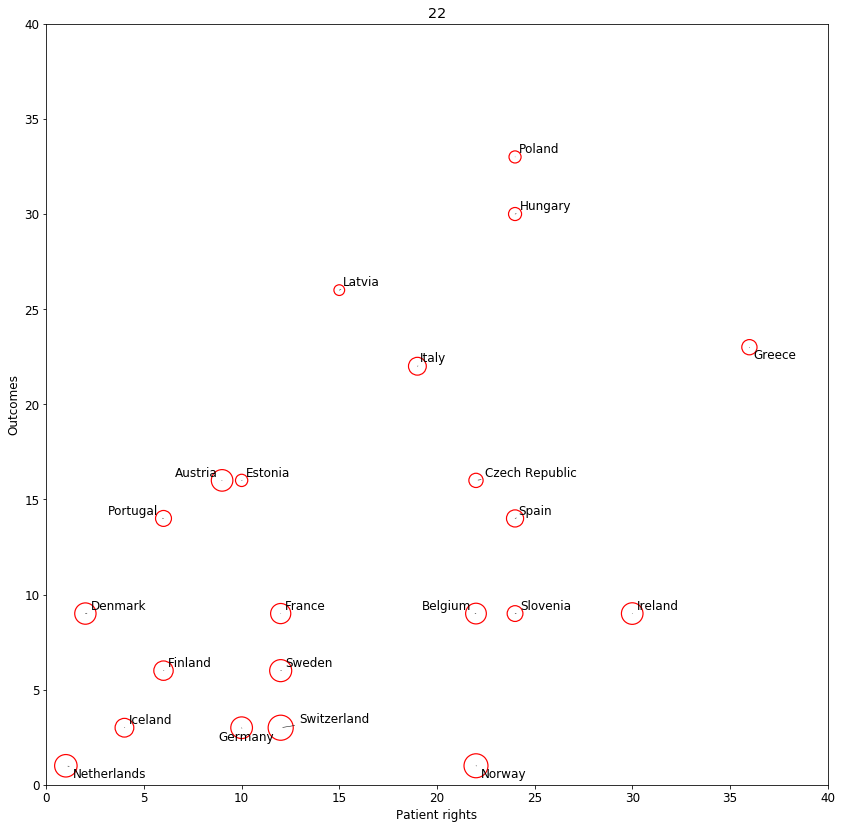

In [43]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_df3(adjust=True):
    mpl.rcParams['font.size'] = 12.0
    plt.figure(figsize = (14, 14))
    plt.scatter(df3.Patientrights, df3.Outcomes, facecolors='none', edgecolors='red', linewidth=1.2, s=0.1*df3.y2012)
    texts = []
    plt.title('Relation between different health parameters')
    plt.xlabel('Patient rights')
    plt.ylabel('Outcomes')
    plt.xlim(0, 40)
    plt.ylim(0, 40)

    for x, y, s in zip(df3['Patientrights'], df3['Outcomes'], df3['Country']):
        texts.append(plt.text(x, y, s, size=12))
    if adjust:
        plt.title(str(adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))))
_ = plot_df3()
plt.show()

The visualization suggests that there is a relation between patient rights and outcomes (the lower the score, the better). The diameter of the circles displays expenditure in 2012, and there is a slight impression that the higher expenditure countries have better patient rights and outcomes.

The visualization used Matplotlib and is just an example how quickly visual insight can be provided after data have been scraped. All using a single Python script.

___
*Any questions or comments?* : Ruthger Righart, <font color="blue">rrighart@googlemail.com</font>
___


## **References**

[1]. Data is the new oil. https://www.changethislimited.co.uk/2017/01/data-is-the-new-oil/

[2]. Data on internet. https://www.livescience.com/54094-how-big-is-the-internet.html

[3]. Beautiful Soup. https://www.crummy.com/software/BeautifulSoup/bs4/

[4]. Healthcare Europe. https://en.wikipedia.org/wiki/Healthcare_in_Europe

[5]. Visualizing European healthcare using Tableau. https://rrighart.github.io/HE-Tableau/

[6]. Scraping tables. https://stackoverflow.com/questions/17196018/extracting-table-contents-from-html-with-python-and-beautifulsoup

[7]. Health expenditure. https://en.wikipedia.org/wiki/List_of_countries_by_total_health_expenditure_per_capita

[8]. Hidden characters. https://stackoverflow.com/questions/31341351/how-can-i-identify-invisible-characters-in-python-strings

[9]. Adjust text package. https://github.com/Phlya/adjustText/blob/master/examples/Examples.ipynb

___


(c) 2017 . https://rrighart.github.io